### Test case LVV-T1839: Verify calculation of RMS width of photometric zeropoint

Verify that the DM system provides code to assess whether the RMS width of the internal photometric zero-point (precision of system uniformity across the sky) for all bands except u-band is less than **PA3 = 10 millimagnitudes**.

**Discussion**: We choose to verify this requirement by comparison of the calibrated photometry resulting from processing by the DM pipelines to the Monster reference catalog. For each visit, the median difference between the `source` table photometry and the reference catalog for high S/N stars is calculated. We will then take the ensemble of all measured median zeropoint offsets, and calculate the RMS of the distribution to represent PA3.

In [1]:
from astropy.table import Table
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_linestyles, get_multiband_plot_symbols

While the [TargetRefcatDeltaPhotomMetrics](https://github.com/lsst/analysis_tools/blob/e52006734b52f2011d899b2a94f549ff4b88daf7/python/lsst/analysis/tools/atools/refCatMatchPlots.py#L778-L855) task to calculate the offsets exists in `analysis_tools`, it is not part of the default pipelines. For this test, we ran the task on the LSSTCam data processed with w_2025_37 of the DRP pipeline. The results are retrieved from the relevant collection below.

In [2]:
testcoll = 'u/jcarlin/src_refmatch_atools_w37'
butler = Butler('/repo/main', collections=[testcoll])

#### Query the Butler for all datasets of type `source_ref_match_photom_metrics`:

In [3]:
srcref_refs = butler.query_datasets('source_ref_match_photom_metrics', collections=testcoll)

Extract the metrics to a table. Note that we take only the first element (i.e., the 0th index) of `photomDiffMetrics`, which is the median `source` - `refcat` offset.

Because this test concerns all bands *except* *u*-band, extract only the *grizy* results.

In [4]:
bands_list = ['g', 'r', 'i', 'z', 'y']
offsets = []
bands = []

for ref in srcref_refs:
    srcref_tmp = butler.get(ref)
    offsets.append(srcref_tmp['photomDiffMetrics'][0].quantity.value)
    bands.append(ref.dataId['band'])

tab = Table([offsets, bands], names=['offset', 'band'])

In [5]:
# Create a dict with indices of entries corresponding to each band:
band_sel_dict = {}

for band in bands_list:
    band_sel_dict[band] = (tab['band'] == band)

#### Plot histograms of the median `source`-`refcat` residuals:

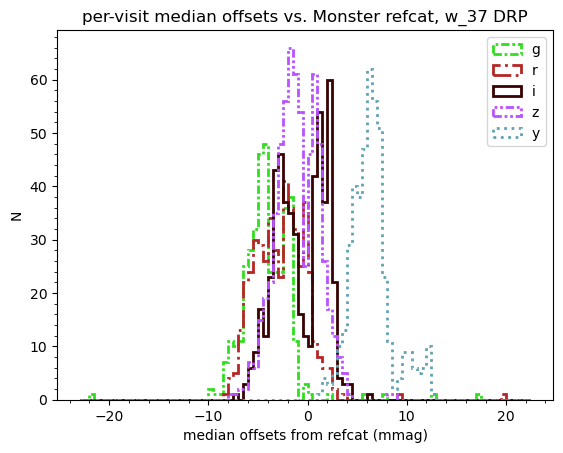

In [6]:
bandcolors = get_multiband_plot_colors()
bandlines = get_multiband_plot_linestyles()

for band in bands_list:
    plt.hist(tab['offset'][band_sel_dict[band]], bins=np.arange(-23, 23, 0.5), histtype='step',
             label=band, color=bandcolors[band], linestyle=bandlines[band],
             linewidth=2)

plt.legend()
plt.minorticks_on()
plt.xlabel('median offsets from refcat (mmag)')
plt.ylabel('N')
plt.title('per-visit median offsets vs. Monster refcat, w_37 DRP')
plt.show()

#### Calculate statistics of the zeropoint offset distributions:

In [7]:
meanvals = []
medianvals = []
stdevvals = []
rmsvals = []

for band in bands_list:
    rmsvals.append(np.sqrt(np.mean(tab['offset'][band_sel_dict[band]]**2)))
    stdevvals.append(np.nanstd(tab['offset'][band_sel_dict[band]]))
    meanvals.append(np.nanmean(tab['offset'][band_sel_dict[band]]))
    medianvals.append(np.nanmedian(tab['offset'][band_sel_dict[band]]))

stats_tab = Table([bands_list, meanvals, medianvals, stdevvals, rmsvals],
                  names = ['band', 'mean', 'median', 'stdev', 'rms'],
                  units = ['', u.mmag, u.mmag, u.mmag, u.mmag],
                  )

stats_tab['mean'].format = '%.3F'
stats_tab['median'].format = '%.3F'
stats_tab['stdev'].format = '%.3F'
stats_tab['rms'].format = '%.3F'

In [8]:
stats_tab

band,mean,median,stdev,rms
,mmag,mmag,mmag,mmag
str1,float64,float64,float64,float64
g,-4.117,-4.294,2.666,4.905
r,-2.688,-2.594,2.653,3.777
i,-0.641,-0.854,3.229,3.292
z,-1.024,-1.154,2.163,2.393
y,6.429,6.308,2.076,6.756


## Results

We have demonstrated that software tools exist to calculate zeropoint offsets, and that those residuals can be easily compiled for analysis. We see that the rms of the zeropoint offsets between calibrated `source` tables and the reference catalog is between 2-7 mmag for each of the `grizy` bands. Because this is less than the specified threshold **PA3 = 10 mmag**, we deem the result of this test a **Pass**.